# Customer Segmentation With A Online Transaction Dataset

Content: <br>
Step 1: Import Necessary Libraries and Modules<br>
Step 2: Load the Dataset<br>
Step 3: Explore and Clean the Dataset<br>
Step 4: Explore the dataset with SQL queries<br>
Step 5: Identifying the probably high profile customers?<br>
Step 6: Creating Customer Categories<br> 
Step 7: Customer Segmentation with KMeans Clustering (inkl Remove Outliers)<br>


## Import Necessary Libraries and Modules

In [14]:
import pandas as pd
import numpy as np
import sqlite3

In [15]:
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

In [16]:
from scipy import stats

In [17]:
import os
os.environ['OMP_NUM_THREADS'] = '1'

## Load the Databse "bootcamp_db"

In [18]:
# connect to db (cleaned w/ 3 tables)
conn = sqlite3.connect("../data/bootcamp_db")

In [19]:
conn

In [20]:
# Doublecheck of the db contains 3tables
sql_query = """SELECT name 
               FROM sqlite_master 
               WHERE type='table';"""

cursor = conn.cursor()

# executing our sql query
cursor.execute(sql_query)

 
# printing all tables list
print(f"List of tables in the database:\n{cursor.fetchall()}")

List of tables in the database:
[('online_transactions',), ('stock_description',), ('online_transactions_cleaned',)]


### Characteristics of online_transactions_cleaned'

In an previous version of "bootcamp_db" the following steps were performed on the tables 'online_transactions' and 'stock_description'. 

- Left JOIN query to add the description from 'stock_description' to the 'online_transactions' table<br>

The join query considers:
- Filling in UNKNOWN' when description is null 
- Creating a the column total_amount_spent by price*quantity 
- Removing rows where the col. stock_code is '?'
- Removing rows where the col. stock_code is BANK CHARGES', 'POST', 'D', 'M', 'CRUK'
- Removing rows where customer_id is blank

The result is the table 'online_transactions_cleaned'<br>
In 'online_transactions_cleaned' the duplicates have been already removed

In [21]:
#Create a dataframe from the table online_transactions_cleaned
ot_cleaned = pd.read_sql_query("""SELECT * FROM online_transactions_cleaned""", conn)

In [22]:
type(ot_cleaned)

pandas.core.frame.DataFrame

In [23]:
ot_cleaned.head()

,invoice,stock_code,description,invoice_date,price,quantity,total_order_value,customer_id,country
0,536370,21791,VINTAGE HEADS AND TAILS CARD GAME,2010-12-01 08:45:00,1.25,24,30.00,u12583,France
1,536373,82494L,WOODEN FRAME ANTIQUE WHITE,2010-12-01 09:02:00,2.55,6,15.30,u1785,United Kingdom
2,536378,21929,JUMBO BAG PINK VINTAGE PAISLEY,2010-12-01 09:37:00,1.95,10,19.50,u14688,United Kingdom
3,536381,37444A,YELLOW BREAKFAST CUP AND SAUCER,2010-12-01 09:41:00,2.95,1,2.95,u15311,United Kingdom
4,536381,15056BL,EDWARDIAN PARASOL BLACK,2010-12-01 09:41:00,5.95,2,11.90,u15311,United Kingdom


In [24]:
ot_cleaned.shape 

(399841, 9)

In [25]:
ot_cleaned.describe()

,price,quantity,total_order_value
count,399841.000000,399841.000000,399841.000000
mean,2.952914,12.224359,20.716904
std,7.317593,250.788860,425.471765
min,0.000000,-80995.000000,-168469.600000
25%,1.250000,2.000000,4.250000
50%,1.950000,5.000000,11.580000
75%,3.750000,12.000000,19.500000
max,1599.260000,80995.000000,168469.600000


#### How to handle the canceled orders?
Cancelation lead to negative values in 'quantity' and 'price'.
The cancealtion entries contain a "C" in the invoice number. The orginial orders are still in the table.
This effects acround 4,2% of the data set (original and cancelled orders).

For the moment: <br>
1) I've decided to postpone finding the solution and concentrate on the steps for data exploration and customer segmentation and
2) I'll go with the workaround by excluding all negative values in 'quantity" and 'price'


In [26]:
#Exlude the data entries with negative values in 'quantity" and 'price'
query_cancelled= """SELECT * 
                    FROM online_transactions_cleaned 
                    WHERE quantity > 0
                        ;"""
otc_fixed = pd.read_sql(query_cancelled, conn)

In [27]:
otc_fixed.describe() 

,price,quantity,total_order_value
count,391334.000000,391334.000000,391334.000000
mean,2.920468,13.174199,22.372879
std,7.267548,181.871884,310.911086
min,0.000000,1.000000,0.000000
25%,1.250000,2.000000,4.950000
50%,1.950000,6.000000,11.900000
75%,3.750000,12.000000,19.800000
max,1599.260000,80995.000000,168469.600000


##  Explore the Dataset 

### How many different types of stocks did the customers purchase?


In [28]:
query_stocks = pd.read_sql_query( """
select count (DISTINCT stock_code) as numbers_of_stocks
from online_transactions_cleaned otc;
""", conn)

query_stocks

,numbers_of_stocks
0,3679


### What are the top ten most popular geographical locations?


In [29]:
country_counts = otc_fixed['country'].value_counts()

In [30]:
# Top 10 Locations
top_10_countries = country_counts.head(10)

top_10_countries

country
United Kingdom    348940
Germany             8644
France              8021
EIRE                7226
Spain               2418
Netherlands         2326
Belgium             1935
Switzerland         1811
Portugal            1416
Australia           1183
Name: count, dtype: int64

### Which country spends the most?

#### by Order value


In [40]:
total_sales_countries = pd.read_sql_query(
    """SELECT country, SUM(total_order_value) AS total_sales_volume
    FROM online_transactions_cleaned otc
    WHERE total_order_value > 0
    GROUP BY country
    ORDER BY SUM (total_order_value) DESC
    LIMIT 10;""", conn)

In [41]:
total_sales_countries

,country,total_sales_volume
0,United Kingdom,7255684.833
1,Netherlands,283889.340
2,EIRE,261888.120
3,Germany,205381.150
4,France,183987.940
5,Australia,138103.810
6,Spain,55706.560
7,Switzerland,52441.950
8,Japan,37416.370
9,Belgium,36927.340


#### by item quantity


In [42]:
total_soldquantity_countries = pd.read_sql_query(
    """SELECT country, SUM(quantity) AS total_solditems
    FROM online_transactions_cleaned otc
     WHERE total_order_value > 0
    GROUP BY country
    ORDER BY  SUM(quantity) DESC
    LIMIT 10;""", conn)

In [43]:
total_soldquantity_countries

,country,total_solditems
0,United Kingdom,4234058
1,Netherlands,200258
2,EIRE,140131
3,Germany,118032
4,France,110597
5,Australia,83890
6,Sweden,36037
7,Switzerland,29980
8,Spain,27724
9,Japan,26016


### Looking at seasonality


In [44]:
#checking which datatype "invoice_date" has
otc_fixed.dtypes

invoice               object
stock_code            object
description           object
invoice_date          object
price                float64
quantity               int64
total_order_value    float64
customer_id           object
country               object
dtype: object

In [45]:
# Convert invoice_date into datetime format
otc_fixed['invoice_date'] = pd.to_datetime(otc_fixed['invoice_date'])

In [46]:
#counter check the data type
print(otc_fixed['invoice_date'].head())

0   2010-12-01 08:45:00
1   2010-12-01 09:02:00
2   2010-12-01 09:37:00
3   2010-12-01 09:41:00
4   2010-12-01 09:41:00
Name: invoice_date, dtype: datetime64[ns]


#### How many unique invoices per month in 2011?

In [47]:
#How many unique invoices per month in 2011?

#Filter year 2011
otc_fixed_2011 = otc_fixed[otc_fixed['invoice_date'].dt.year == 2011].copy()

# Create a variable to extract the month
otc_fixed_2011['Month'] = otc_fixed_2011['invoice_date'].dt.month

# Create a df while using the groupby function to count the number of unique invoices per month
monthly_invoices_2011 = pd.DataFrame(otc_fixed_2011.groupby(['Month']).nunique()['invoice'])

print(monthly_invoices_2011)

       invoice
Month         
1          983
2          993
3         1312
4         1139
5         1544
6         1390
7         1321
8         1269
9         1740
10        1903
11        2643
12         776


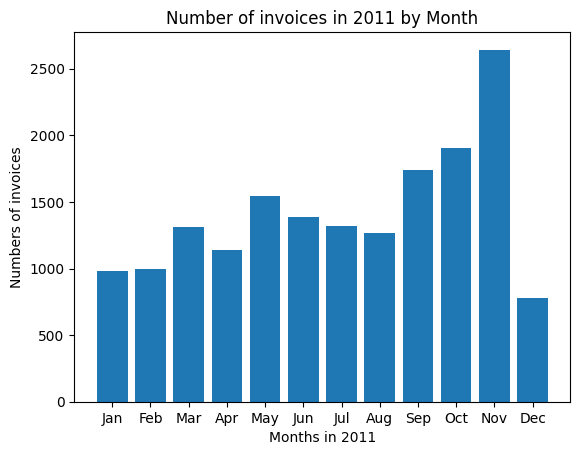

In [48]:
# Plotting the invoices per month in 2011 

plt.bar(monthly_invoices_2011.index, monthly_invoices_2011['invoice'])
plt.title ("Number of invoices in 2011 by Month")
plt.xlabel('Months in 2011')
plt.ylabel('Numbers of invoices')
plt.xticks(range (1,13))
plt.xticks(monthly_invoices_2011.index, 
           ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

<b>Result:</b>
- In the middle of the year (may, june) is a slight peak.
- From September on the invoices rise with a peak in November. Assumption: Preparing for the Christmas season

#### Which day of the week has the highest number of transactions?

In [49]:
# Create week day name
otc_fixed_2011['weekday_name'] = otc_fixed_2011['invoice_date'].dt.day_name()

# Count invoices per week day
weekday_counts = otc_fixed_2011['weekday_name'].value_counts().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])

In [50]:
print(weekday_counts)

weekday_name
Monday       60029.0
Tuesday      62440.0
Wednesday    62508.0
Thursday     73293.0
Friday       50831.0
Saturday         NaN
Sunday       56652.0
Name: count, dtype: float64


<Axes: xlabel='weekday_name'>

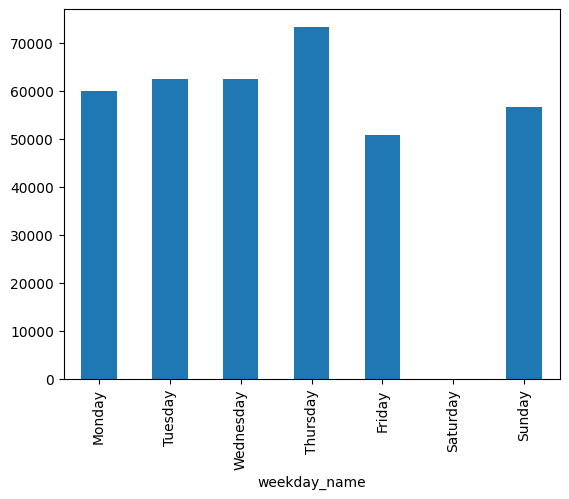

In [51]:
# simple & quick visualisation
weekday_counts.plot(kind='bar')

##### Conclusion: 
On Thursday, the order volume is slightly higher than the rest of the week. For the rest of the weekdays the orders are distributed almost evenly, except for saturday. on saturdays are not orders placed <br>

Note to myself:
<b>tod<b>o:
give a summary in words about the findings and dimenions of the database and numbers

### Which customers have purchased the most ?

In [52]:
# Calculating the sum of order value per customer_id 

otc_fixed_salesbycustomer = pd.DataFrame(otc_fixed.groupby(['customer_id']).sum(numeric_only=True)['total_order_value'])

In [53]:
#just trying out the sort.value
otc_fixed_salesbycustomer.sort_values(by=['total_order_value'],ascending = False)

,total_order_value
customer_id,
u14646,279138.02
u18102,259657.30
u1745,194390.79
u16446,168472.50
u14911,140336.83
...,...
u17956,12.75
u14792,6.20
u16454,5.90


In [54]:
# Average spending by customer
otc_fixed_salesbycustomer['total_order_value'].mean()

2019.669700807382

In [55]:
#Which customers purchased above the average (= high profile customers)?
high_profil_customer = otc_fixed_salesbycustomer[(otc_fixed_salesbycustomer['total_order_value']> 2019.669700807382)]


In [56]:
high_profil_customer.sort_values(by=['total_order_value'],ascending = False)


,total_order_value
customer_id,
u14646,279138.02
u18102,259657.30
u1745,194390.79
u16446,168472.50
u14911,140336.83
...,...
u12501,2025.39
u16409,2022.98
u14482,2022.81


Note to myself: To create "high_profil_customer" is not really necessary. This will be covered by the segmentation by Sales Amount. see below


In [57]:
# Which customers have ordered more than once?
otc_fixed_frequency = pd.DataFrame(otc_fixed.groupby('customer_id')['invoice'].nunique().reset_index())
otc_fixed_frequency.columns = ['customer_id', 'frequency']

In [58]:
otc_fixed_frequency

,customer_id,frequency
0,u12346,1
1,u12347,7
2,u12348,4
3,u12349,1
4,u1235,1
...,...,...
4330,u1828,1
4331,u18281,1
4332,u18282,2
4333,u18283,16


In [59]:
#Customers, who ordered more than 1x are "recurring customers" ->  = recur_custom

recur_custom = otc_fixed_frequency[(otc_fixed_frequency['frequency']> 1)]

In [60]:
recur_custom.sort_values(by=['frequency'],ascending = False)                       

,customer_id,frequency
326,u12748,206
1880,u14911,199
4008,u17841,124
562,u13089,97
2177,u15311,91
...,...,...
2015,u15101,2
3334,u16897,2
2007,u15092,2
2003,u15088,2


In [61]:
recur_custom.describe()

,frequency
count,2829.000000
mean,5.974549
std,8.996899
min,2.000000
25%,2.000000
50%,4.000000
75%,6.000000
max,206.000000


-> The <b>average customer</b>: <br>
- has ordered ca. 6 times and
- purchased an order value of 2019€.

## Creating Customer Categories 
### By Frequency


In [62]:
# creating new column with the number of orders per customer = "frequency"

def categorize_customers(frequency):
    if 1 <= frequency <= 5:
        return 'Occasional Customers'
    elif 6 <= frequency <=100:
        return 'Regular Customers'
    else:
        return 'Loyal Customers'

otc_fixed_frequency['category'] = otc_fixed_frequency['frequency'].apply(categorize_customers)


In [63]:
otc_fixed_frequency.head(10)

,customer_id,frequency,category
0,u12346,1,Occasional Customers
1,u12347,7,Regular Customers
2,u12348,4,Occasional Customers
3,u12349,1,Occasional Customers
4,u1235,1,Occasional Customers
5,u12352,7,Regular Customers
6,u12353,1,Occasional Customers
7,u12354,1,Occasional Customers
8,u12355,1,Occasional Customers
9,u12356,3,Occasional Customers


In [64]:
print(otc_fixed_frequency['category'].value_counts())

category
Occasional Customers    3470
Regular Customers        862
Loyal Customers            3
Name: count, dtype: int64


<Axes: xlabel='category'>

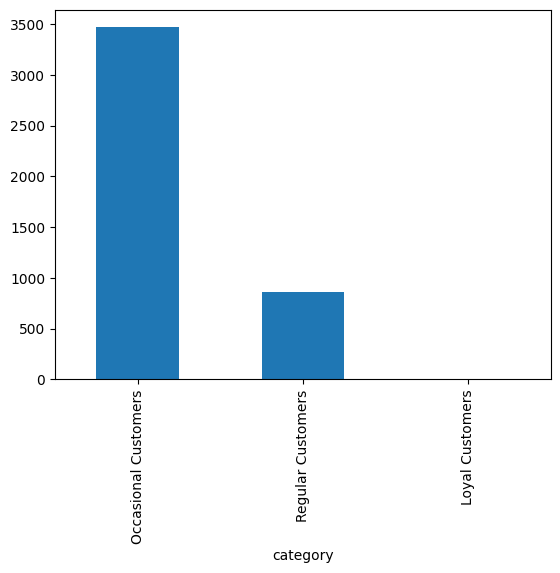

In [65]:
(otc_fixed_frequency['category'].value_counts()).plot(kind='bar')

### By Sales Amount

In [66]:
def categorize_salesamount(total_order_value):
    if 1 <= total_order_value <= 499:
        return 'Low-spending Customers'
    elif 500 <= total_order_value <= 2020:
        return 'Mid-spending Customers'
    else:
        return 'High-spending Customers'

otc_fixed_salesbycustomer['sales category'] = otc_fixed_salesbycustomer['total_order_value'].apply(categorize_salesamount)

otc_fixed_salesbycustomer.head()

,total_order_value,sales category
customer_id,,
u12346,77183.60,High-spending Customers
u12347,4310.00,High-spending Customers
u12348,1437.24,Mid-spending Customers
u12349,1457.55,Mid-spending Customers
u1235,294.40,Low-spending Customers


In [67]:
print(otc_fixed_salesbycustomer['sales category'].value_counts())

sales category
Low-spending Customers     1775
Mid-spending Customers     1682
High-spending Customers     878
Name: count, dtype: int64


<Axes: xlabel='sales category'>

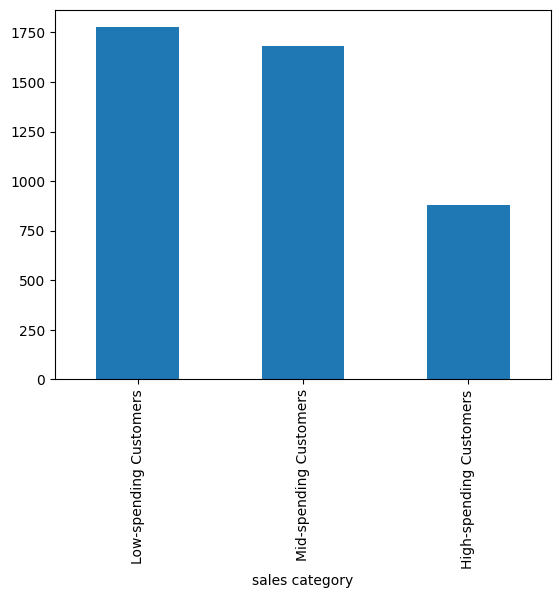

In [68]:
(otc_fixed_salesbycustomer['sales category'].value_counts()).plot(kind='bar')

##### Next Questions/Tasks for later:
- do a RFM segementation maybe
- do some analysis based on the  segments.
- what should the company do with these segments?!


## Customer Segmentation with KMeans Clustering 

### Aggregating Data at Customer Level
aggregation on customer level to analyze each customer’s purchasing behavior.

In [69]:
# Aggregate data by CustomerID
customer_data = otc_fixed.groupby('customer_id').agg({
    'invoice_date': lambda x: (x.max() - x.min()).days,
    'invoice': 'count',
    'total_order_value': 'sum'
}).rename(columns={'invoice_date': 'recency', 'invoice': 'frequency'})


In [70]:
customer_data.head()

,recency,frequency,total_order_value
customer_id,,,
u12346,0,1,77183.60
u12347,365,182,4310.00
u12348,282,27,1437.24
u12349,0,72,1457.55
u1235,0,16,294.40


### Removing Outliers

recency: 


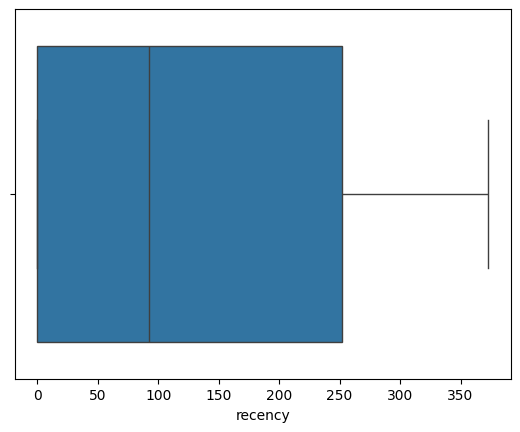

frequency: 


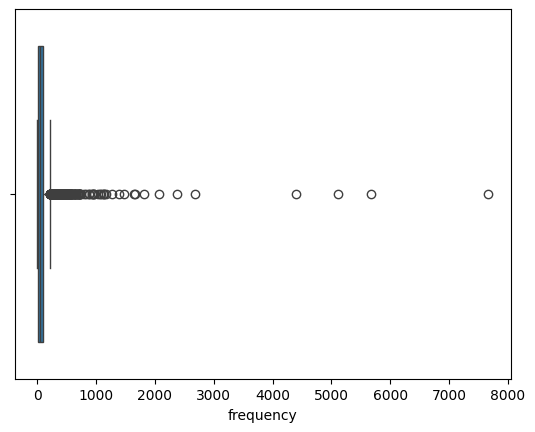

total_order_value: 


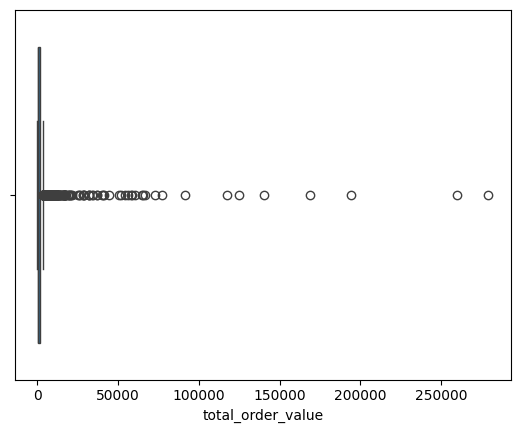

In [71]:
# Visualise the Outliers
list = ['recency','frequency','total_order_value']
for i in list:
    print(str(i)+': ')
    ax = sns.boxplot(x=customer_data[str(i)])
    plt.show()

Note to myself:
z score
"remove outliers in every column of our dataframe (We are going to remove every data point with a Z-Score>=3):"

In [72]:
#Reindex so that the customer_id is not the index anymore, but a column, that can be filtred out
new_df_reindexed = customer_data.reset_index()

In [73]:
new_df_reindexed.head()

,customer_id,recency,frequency,total_order_value
0,u12346,0,1,77183.60
1,u12347,365,182,4310.00
2,u12348,282,27,1437.24
3,u12349,0,72,1457.55
4,u1235,0,16,294.40


In [74]:
# remove the customer_id column
new_df = new_df_reindexed[['recency','frequency','total_order_value']]

# Remove outliers
z_scores = stats.zscore(new_df)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
new_df_ol_removed = new_df[filtered_entries]

In [75]:
new_df_ol_removed.head()

,recency,frequency,total_order_value
1,365,182,4310.00
2,282,27,1437.24
3,0,72,1457.55
4,0,16,294.40
5,260,77,1385.74


### Applying the Elbow Method
To determine the optimal number of clusters for KMeans

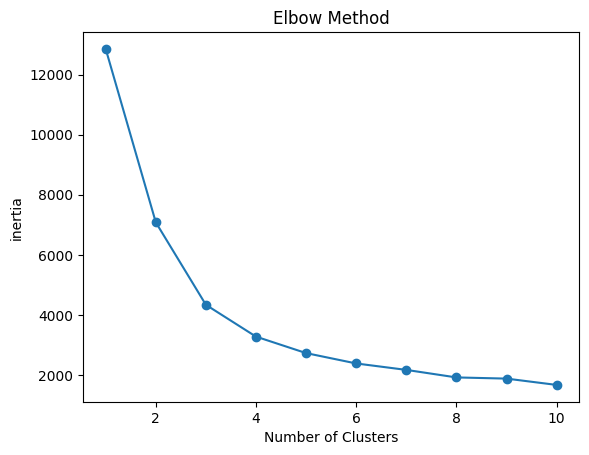

In [76]:
# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(new_df_ol_removed[['recency', 'frequency', 'total_order_value']])

# Determine the optimal number of clusters using the Elbow Method
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# Plot the inertia for each number of clusters
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('inertia')
plt.show()

In [77]:
type(scaled_features)

numpy.ndarray

### Implementing K-means Clustering

In [78]:
# TODO: Create an instance of KMeans with the optimal number of clusters and fit it to the scaled data

optimal_clusters = 4
kmeans = KMeans(n_clusters= optimal_clusters, init="k-means++",n_init='auto', random_state=42)

# Fit the model to the scaled data

new_df_ol_removed = new_df_ol_removed.copy()
new_df_ol_removed["cluster"] = kmeans.fit_predict(scaled_features)
#(X, y=None, sample_weight=None)

In [79]:
# Calculate the silhouette score for the model.

silhouette_avg = silhouette_score(scaled_features, new_df_ol_removed["cluster"])

print(f'Silhouette Score: {silhouette_avg}')

#Reminder: Values closer to 1 are ideal
                              

Silhouette Score: 0.544070080446038


### Visualize the clusters

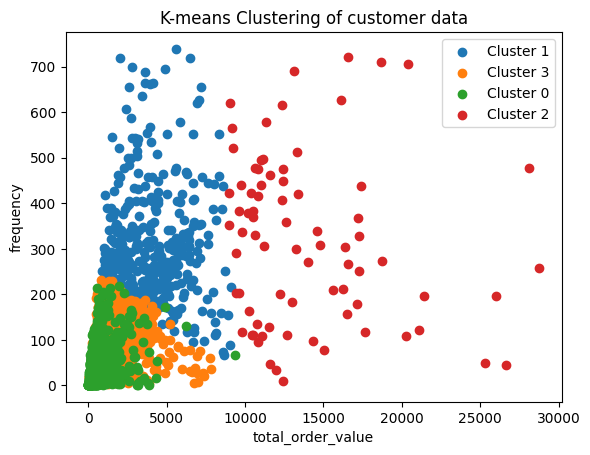

In [80]:
# Erstellen Sie den Scatter-Plot für jeden Cluster einzeln
clusters = new_df_ol_removed["cluster"].unique()

for cluster in clusters:
    cluster_data = new_df_ol_removed[new_df_ol_removed["cluster"] == cluster]
    plt.scatter(cluster_data['total_order_value'], 
                cluster_data['frequency'], 
                label=f'Cluster {cluster}')  # Label für die Legende

# Achsen und Titel
plt.xlabel('total_order_value')
plt.ylabel('frequency')
plt.title('K-means Clustering of customer data')

plt.legend()
plt.show()

In [81]:
# Analyzing cluster characteristics
cluster_analysis = new_df_ol_removed.groupby('cluster').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'total_order_value': 'mean'
})

In [82]:
cluster_analysis

,recency,frequency,total_order_value
cluster,,,
0,22.876897,31.082631,509.998349
1,290.534177,300.055696,4100.324557
2,326.753247,318.844156,13962.683377
3,245.934028,78.916667,1488.128799


In [83]:
new_df_ol_removed["cluster"].value_counts()

cluster
0    2372
3    1440
1     395
2      77
Name: count, dtype: int64

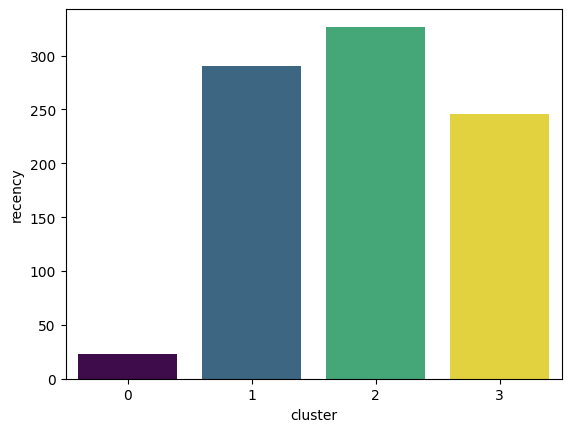

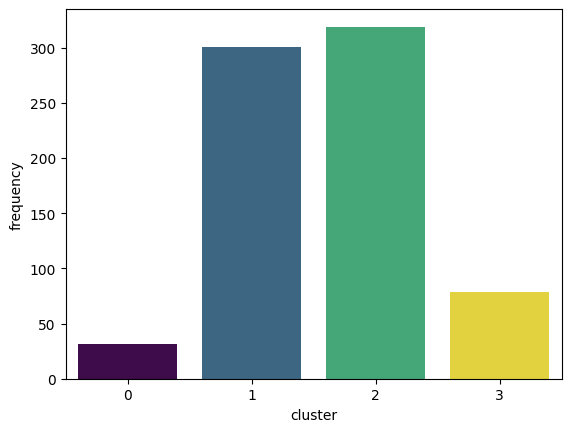

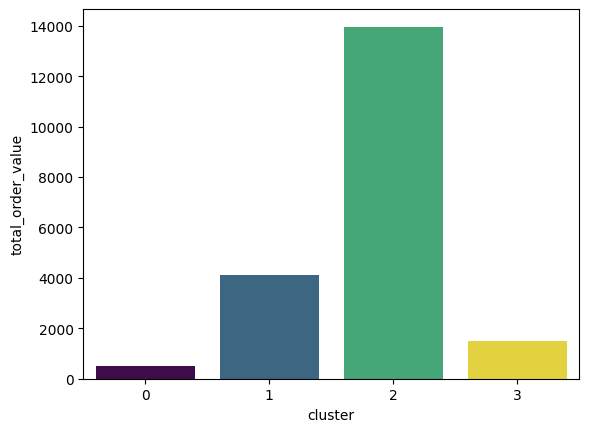

In [90]:
# Calculation the mean for each cluster
avg_df = new_df_ol_removed.groupby(['cluster'], as_index=False).mean()

# Convert into a string 
avg_df['cluster'] = avg_df['cluster'].astype(str)

# Anzahl der Cluster ermitteln
clusters = avg_df['cluster'].unique()

# colour palette based on the number of clusters
cmap = plt.get_cmap('viridis') 
colors = cmap(np.linspace(0, 1, len(clusters)))

# Assign colour palette to the clusters 
palette = dict(zip(clusters, colors))

# Create barplots für recency, frequncy and total_order_value 
for i in list:
    sns.barplot(x='cluster', y=str(i), data=avg_df, palette=palette, hue='cluster',dodge=False, legend=False)
    plt.show()



## Status of Work In Progress

Didnt make a conclusion yet, because the scatter plot looked odd to me. And their is still open how to handle the canceled orders properly. And would like to compare how others get their results and if their steps and results are very different to mine. Or try to make a RFM segmenation instead.
